<a href="https://colab.research.google.com/github/yusica09/seoul-AI-hub-study/blob/main/3%EC%A3%BC%EC%B0%A8/Speech_recognition_Spectrogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speech spectrogram classification

## Spectrogram 데이터를 이용해 음성을 분류하는 모델을 제작해보자.

## challenge
### Task
* 1초 길이의 오디오 음성데이터를 이용해 단어를 분류하는 것이 목표입니다.
* 주어진 데이터를 이용해 딥러닝 트레이닝 과정을 구현해 보는것이 목표입니다.
* This code is borrowed from [Kaggle/TensorFlow Speech Recognition Challenge](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge).
* This is version 0.01 of the data set containing 64,727 audio files, released on August 3rd 2017.
* **챌린지에서 사용하는 데이터는 Wave에서 Spectrogram으로 변환된 데이터입니다.**

### Import packages

* 우리가 사용할 packages 를 import 하는 부분 입니다.
* 필요에 따른 packages를 선언합니다.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import librosa
import librosa.display
import matplotlib.pyplot as plt

import os
from os.path import isdir, join

import random
import copy

tf.__version__

'2.15.0'

### Setting Dataset

* Colab 적용을 위한 변수 지정 및 드라이브 마운트

In [2]:
use_colab = True
assert use_colab in [True, False]

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
if use_colab:
    DATASET_PATH = "/content/drive/MyDrive/Datasets"
else:
    DATASET_PATH = "./"

### Dataset Shape
* 불러온 데이터셋의 shape을 확인해보자.

In [5]:
data_wav = np.load(os.path.join(DATASET_PATH, "speech_spec_8000.npy"))
print(data_wav.shape)
# 50620, 130, 126, 1

(50620, 130, 126)


In [6]:
(-1, data_wav.shape[1], data_wav.shape[2], 1)

(-1, 130, 126, 1)

* Spectrogram으로 변환한 데이터를 plot 해본다.

* librosa

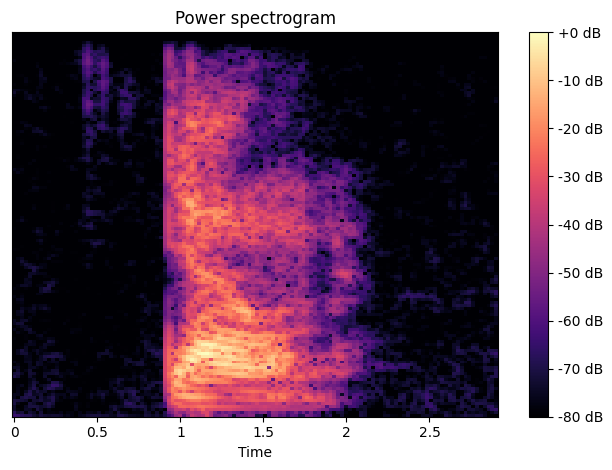

In [7]:
librosa.display.specshow(librosa.amplitude_to_db(data_wav[219], ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

* 이런 경우 transfer learning 사용 불가능. (채널의 개수 때문)

* 전체 데이터셋의 wave 데이터를 spectrogram으로 변환한다.

### Target_list 설정
* 데이터셋은 기본적으로 총 12개의 클래스로 나누어져있다.
```
['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
```
* 해당 클래스로 나누어진 label을 학습 가능한 형태로 처리 후 데이터셋 제작

In [8]:
data_label = np.load(os.path.join(DATASET_PATH, "speech_label_8000.npy"))
print(data_label.shape)

(50620, 1)


In [9]:
# label 전처리
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
##################################################
##### 주어진 label => idx 형태로 변경해주셔야합니다. #####
##################################################
new_target_list = dict() # 사전에 입력
for i, l in enumerate(target_list):
    new_target_list[l] = i
target_list = new_target_list

target_list

{'yes': 0,
 'no': 1,
 'up': 2,
 'down': 3,
 'left': 4,
 'right': 5,
 'on': 6,
 'off': 7,
 'stop': 8,
 'go': 9,
 'unknown': 10,
 'silence': 11}

### label을 리스트로 만들어주는 과정을 잊지말기.


In [10]:
temp = [] # List
for v in data_label:
    temp.append(target_list[v[0]])
data_label = np.array(temp)

print(data_label)
del temp

[ 3  3  3 ... 11 11 11]


### Model dataset setting
* 변환된 데이터를 이용해서 학습에 활용할 데이터셋을 설정한다.
    * data -> data_wav
    * label -> data_label

In [11]:
train_wav, test_wav, train_label, test_label = train_test_split(data_wav,
                                                                data_label,
                                                                test_size=0.1,
                                                                shuffle=True)

# reshape for conv layers Conv2D -> 차원이 더 늘어납니다. 데이터 shape도 바뀝니다!
train_wav = train_wav.reshape(-1, 130,126,1)
test_wav = test_wav.reshape(-1, 130,126,1)

print(train_wav.shape)
print(test_wav.shape)
print(train_label.shape)
print(test_label.shape)

del data_wav # 메모리 관리를 위해 변수 삭제
del data_label

(45558, 130, 126, 1)
(5062, 130, 126, 1)
(45558,)
(5062,)


In [12]:
print('Train_Wav Demension : ' + str(np.shape(train_wav)))
print('Train_Label Demension : ' + str(np.shape(train_label)))
print('Test_Wav Demension : ' + str(np.shape(test_wav)))
print('Test_Label Demension : ' + str(np.shape(test_label)))
print('Number Of Labels : ' + str(len(target_list)))

Train_Wav Demension : (45558, 130, 126, 1)
Train_Label Demension : (45558,)
Test_Wav Demension : (5062, 130, 126, 1)
Test_Label Demension : (5062,)
Number Of Labels : 12


### Hyper-parameters setting
* 학습 전반에서 사용할 batch size, epoch, checkpoint dir을 설정한다.

In [13]:
# the save point
if use_colab:
    checkpoint_dir ='./drive/MyDrive/train_ckpt/spectrogram/exp1'
    if not os.path.isdir(checkpoint_dir):
        os.makedirs(checkpoint_dir)
else:
    checkpoint_dir = 'spectrogram/exp1'

### Dataset 구성
* 전처리가 완료된 데이터들을 이용해서 Train, Test Dataset을 직접 구성해봅시다.
* 학습에 사용할 Loss Function의 설정을 고려해 제작


In [14]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

In [15]:
# 전체 데이터셋 구성
batch_size = 16
max_epochs = 10

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav[:5000], train_label[:5000]))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.shuffle(len(train_wav)).repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav[:5000], test_label[:5000]))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 130, 126, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 12), dtype=tf.float32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 130, 126, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 12), dtype=tf.float32, name=None))>


### Dataset 구성 검증
```
<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
```

## Model 구현
* 제시된 모델을 구현해보고, 더 좋은 성능으로 튜닝해보자.

    * inputs = [batch_size, 130, 126, 1]
    * conv1 = [batch_size, 65, 63, 16]
    * conv2 = [batch_size, 33, 32, 32]
    * conv3 = [batch_size, 17, 16, 64]
    * desne = [batch_size, 64]
    * output = [batch_size, 12]






In [16]:
input_tensor = layers.Input(shape=(130,126,1,))

x = layers.Conv2D(16,3, padding='same', activation='relu')(input_tensor)
skip_1 = layers.Conv2D(16, 3, strides=2, padding='same', activation='relu')(x)

x = layers.Conv2D(32, 3, padding='same', activation='relu')(skip_1)
x = tf.concat([x, skip_1], axis=-1)
skip_2 = layers.Conv2D(32, 3, strides=2, padding='same', activation='relu')(x)

x = layers.Conv2D(64, 3, padding='same', activation='relu')(skip_2)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')(x)

x = layers.Conv2D(128, 3, padding='same', activation='relu')(skip_3)
x = layers.Conv2D(128, 39, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.Conv2D(128, 3, strides=2, padding='same', activation='relu')(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

print(x.shape)

output_tensor = layers.Dense(12)(x)

model = tf.keras.Model(input_tensor, output_tensor)

(None, 64)


* 구현된 모델을 어떻게 학습시킬 것인지 구성해봅시다.

In [17]:
optimizer=tf.keras.optimizers.Adam(1e-3)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), # BinaryCrossentropy()
             optimizer=optimizer,
             metrics=['accuracy'])

### 모델 Output 확인
* 총 12개의 예측 데이터가 출력되는지 확인해봅시다.

In [18]:
# without training, just inference a model:
predictions = model(train_wav[0:1], training=False)
print("Predictions: ", predictions.numpy())

Predictions:  [[ 0.0027291  -0.01671162  0.0110589   0.01143799  0.01561471 -0.00134675
   0.00770889 -0.02349209 -0.02679513  0.02782051  0.02421635 -0.01710924]]


* 최종 모델 구성을 확인 후 모델을 저장할 체크포인트를 구성해봅시다.

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 130, 126, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 130, 126, 16)         160       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 65, 63, 16)           2320      ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 65, 63, 32)           4640      ['conv2d_1[0][0]']            
                                                                                              

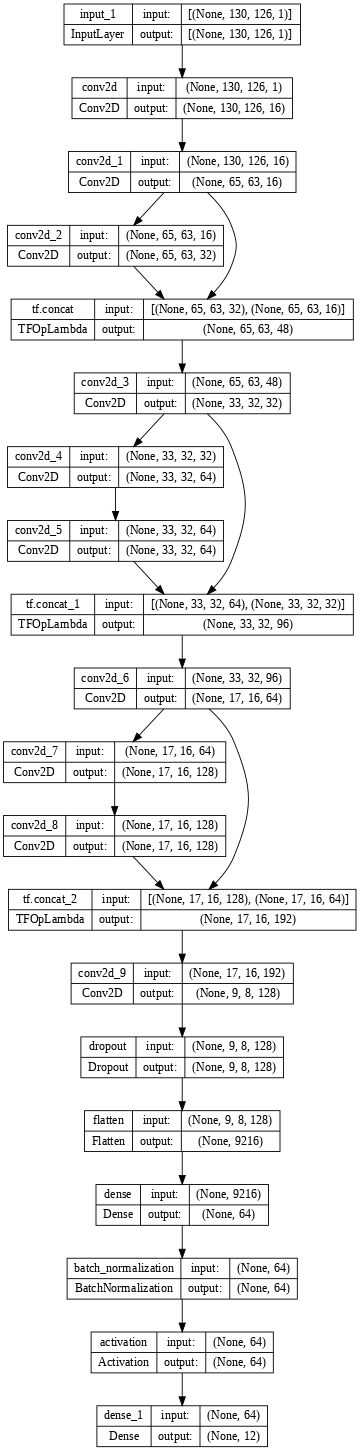

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [21]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto', # max, min, auto
                                                 save_best_only=True,
                                                 verbose=1)
# 추가 callback 함수를 구현해보세요!
# TODO

## Training
* 위에서 구현한 데이터셋, 모델들을 fit 함수를 이용해 학습을 시켜봅시다.

In [22]:
# model.fit model.fit_generator는 model.fit으로 통일되었습니다.
# tf.data.Dataset은 generator 입니다.
history = model.fit(train_dataset,
                    epochs=max_epochs,
                    steps_per_epoch=len(train_wav[:5000]) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav[:5000]) // batch_size,
                    callbacks=[cp_callback])

Epoch 1/10
312/312 [==============================] - ETA: 0s - loss: 1.8732 - accuracy: 0.3658
Epoch 1: val_loss improved from inf to 1.23546, saving model to ./drive/MyDrive/train_ckpt/spectrogram/exp1
312/312 [==============================] - 61s 151ms/step - loss: 1.8732 - accuracy: 0.3658 - val_loss: 1.2355 - val_accuracy: 0.6374
Epoch 2/10
312/312 [==============================] - ETA: 0s - loss: 0.8129 - accuracy: 0.7430
Epoch 2: val_loss improved from 1.23546 to 0.76351, saving model to ./drive/MyDrive/train_ckpt/spectrogram/exp1
312/312 [==============================] - 49s 158ms/step - loss: 0.8129 - accuracy: 0.7430 - val_loss: 0.7635 - val_accuracy: 0.7436
Epoch 3/10
312/312 [==============================] - ETA: 0s - loss: 0.5256 - accuracy: 0.8393
Epoch 3: val_loss improved from 0.76351 to 0.50198, saving model to ./drive/MyDrive/train_ckpt/spectrogram/exp1
312/312 [==============================] - 50s 160ms/step - loss: 0.5256 - accuracy: 0.8393 - val_loss: 0.5020 -

* 학습 결과 확인

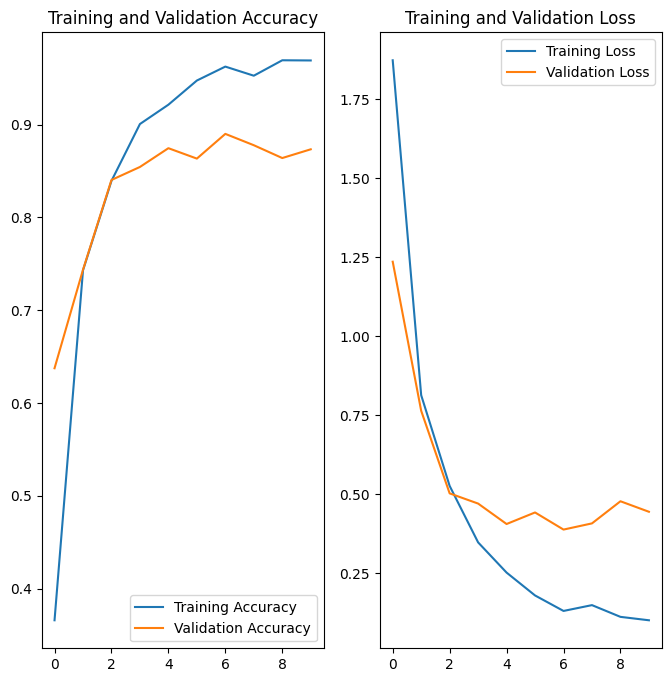

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Evaluation
* Test dataset을 이용해서 모델의 성능을 평가합니다.

In [24]:
model.load_weights(checkpoint_dir)

In [25]:
results = model.evaluate(test_dataset)

313/313 [==============================] - 8s 27ms/step - loss: 0.3874 - accuracy: 0.8898


### 스코어 결과
* 위의 스코어는 분류모델에 적용되는 스코어입니다.
* 모델의 크기 (MB) 와 정확도를 이용해 스코어를 출력합니다.

In [26]:
def final_score():
    print("Model params num : " + str(model.count_params()))
    print("Accuracy : " + str(results[1]))

    s = (model.count_params() * 32) / (1024 ** 2)
    score = 50 * (results[1] + min((1/s), 1))

    print("score : " + str(score))

In [27]:
final_score()

Model params num : 25938044
Accuracy : 0.8898000121116638
score : 44.55316650968915
